In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# PARTE 1: ANÁLISIS SUPERVISADO (REGRESIÓN)
# 1. Carga y Limpieza
df = pd.read_csv('articulos_ml.csv')
# Eliminamos columnas no numéricas o irrelevantes para la predicción numérica directa
df_clean = df.drop(['Title', 'url'], axis=1)
# Eliminamos filas con datos faltantes
df_clean.dropna(inplace=True)

# 2. Selección de Variables
# X: Features (Palabras, Enlaces, Comentarios, Imágenes, Días pasados)
X = df_clean[['Word count', '# of Links', '# of comments', '# Images video', 'Elapsed days']]
# y: Target (Shares)
y = df_clean['# Shares']

# 3. Split (Entrenamiento 80% - Prueba 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Entrenamiento del Modelo (Random Forest)
model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model_rf.fit(X_train, y_train)

# 5. Predicción
y_pred = model_rf.predict(X_test)

: 

In [2]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

R2 Score: -0.4211
RMSE: 25765.80


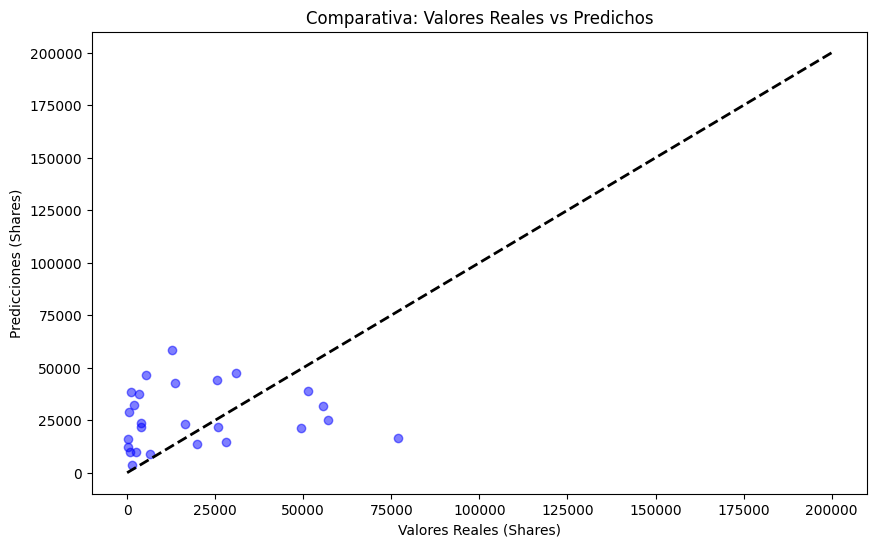

In [3]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2) # Línea diagonal
plt.xlabel('Valores Reales (Shares)')
plt.ylabel('Predicciones (Shares)')
plt.title('Comparativa: Valores Reales vs Predichos')
plt.show()

In [4]:
# PARTE 2: ANÁLISIS SUPERVISADO (CLASIFICACIÓN)

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Carga
df_diabetes = pd.read_csv('diabetes.csv')

# 2. Selección de Variables
X = df_diabetes.drop('Outcome', axis=1) # Todas las columnas menos el resultado
y = df_diabetes['Outcome']

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Entrenamiento y Optimización (Poda del árbol)
# Limitamos max_depth a 3 para obtener un árbol legible y generalizable
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# 5. Predicción
y_pred_class = clf.predict(X_test)

In [5]:
print("Accuracy:", accuracy_score(y_test, y_pred_class))
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred_class))

Accuracy: 0.7597402597402597

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82        99
           1       0.68      0.62      0.65        55

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154



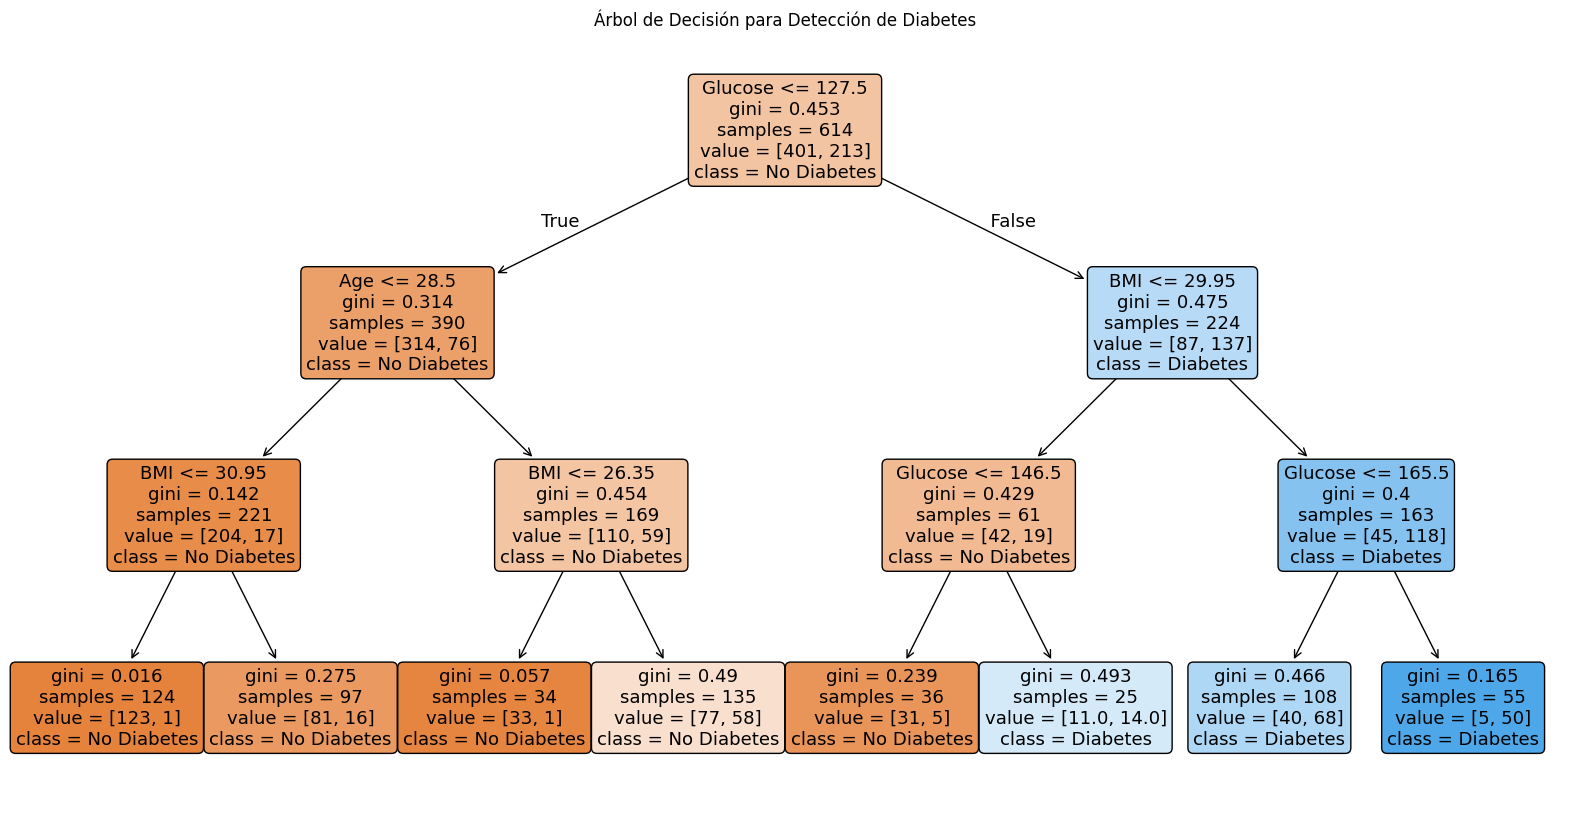

In [6]:
plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'], filled=True, rounded=True)
plt.title('Árbol de Decisión para Detección de Diabetes')
plt.show()

In [8]:
# PARTE 3: ANÁLISIS NO SUPERVISADO (AGRUPACIÓN)
from sklearn.cluster import KMeans

# 1. Carga
df_store = pd.read_csv('cliente_tienda.csv')

# 2. Selección de Variables (Ingresos y Score de Gastos)
# Asumimos que están en las columnas índice 3 y 4
X_cluster = df_store.iloc[:, [3, 4]].values 

# 3. Optimización: Método del Codo (Elbow Method)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_cluster)
    wcss.append(kmeans.inertia_)

# 4. Entrenamiento con el K óptimo (Generalmente 5 para este dataset)
kmeans_opt = KMeans(n_clusters=5, init='k-means++', random_state=42)
y_kmeans = kmeans_opt.fit_predict(X_cluster)

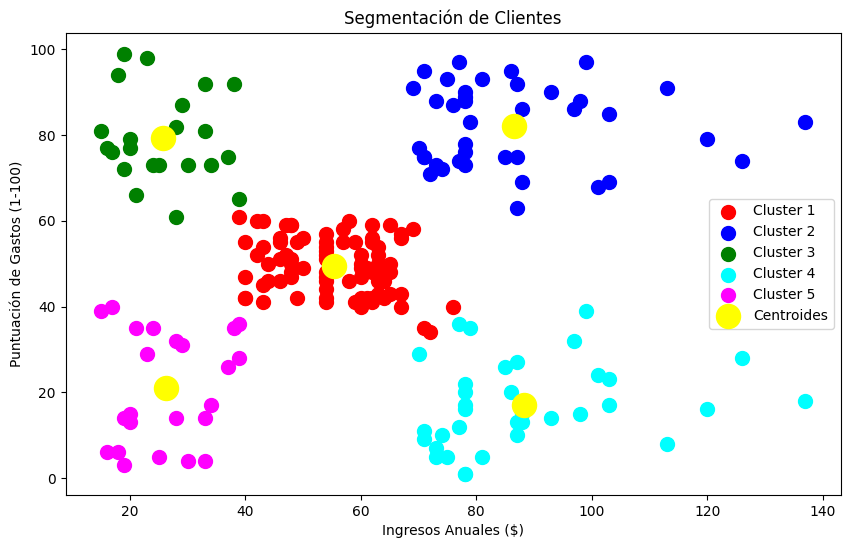

In [9]:
# Gráfica de los Clusters
plt.figure(figsize=(10,6))
plt.scatter(X_cluster[y_kmeans == 0, 0], X_cluster[y_kmeans == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(X_cluster[y_kmeans == 1, 0], X_cluster[y_kmeans == 1, 1], s=100, c='blue', label='Cluster 2')
plt.scatter(X_cluster[y_kmeans == 2, 0], X_cluster[y_kmeans == 2, 1], s=100, c='green', label='Cluster 3')
plt.scatter(X_cluster[y_kmeans == 3, 0], X_cluster[y_kmeans == 3, 1], s=100, c='cyan', label='Cluster 4')
plt.scatter(X_cluster[y_kmeans == 4, 0], X_cluster[y_kmeans == 4, 1], s=100, c='magenta', label='Cluster 5')

# Centroides
plt.scatter(kmeans_opt.cluster_centers_[:, 0], kmeans_opt.cluster_centers_[:, 1], s=300, c='yellow', label='Centroides')
plt.title('Segmentación de Clientes')
plt.xlabel('Ingresos Anuales ($)')
plt.ylabel('Puntuación de Gastos (1-100)')
plt.legend()
plt.show()

In [10]:
# PARTE 4: ANÁLISIS NO SUPERVISADO (REDUCCIÓN DE DIMENSIONALIDAD)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Carga
df_iris = pd.read_csv('Iris.csv')

# 2. Separación
# Quitamos ID y la etiqueta (Species) para el PCA
X_iris = df_iris.drop(['Id', 'species'], axis=1, errors='ignore') 
y_iris = df_iris['species'] # Guardamos las etiquetas para colorear la gráfica luego

# 3. Estandarización (Crucial para PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_iris)

# 4. Aplicación de PCA
# Reducimos a 2 componentes para visualización 2D
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

# Crear DataFrame con los resultados
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
finalDf = pd.concat([principalDf, df_iris[['species']]], axis=1)

In [11]:
# Verificación de varianza explicada
print("Varianza explicada por componente:", pca.explained_variance_ratio_)
print("Varianza total acumulada:", sum(pca.explained_variance_ratio_))

Varianza explicada por componente: [0.72770452 0.23030523]
Varianza total acumulada: 0.9580097536148199


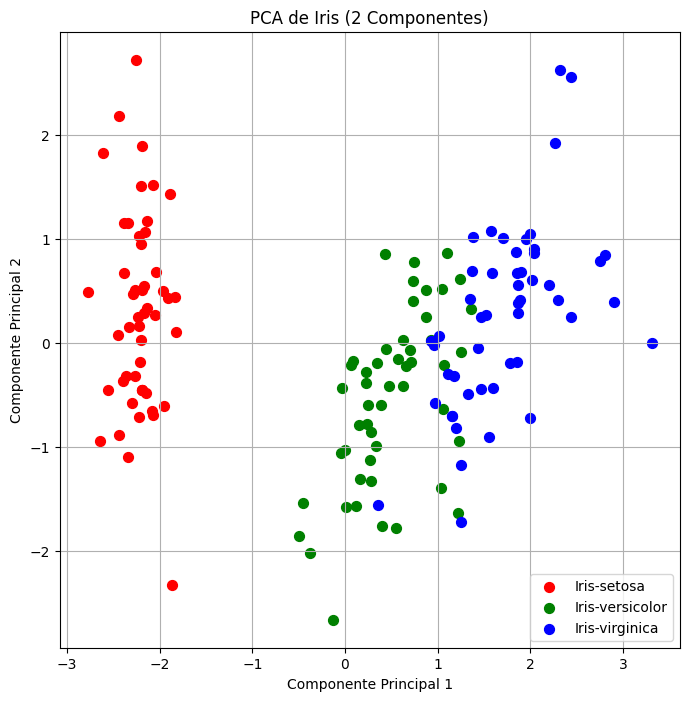

In [12]:
plt.figure(figsize=(8,8))
targets = df_iris['species'].unique()
colors = ['r', 'g', 'b']

for target, color in zip(targets, colors):
    indicesToKeep = finalDf['species'] == target
    plt.scatter(finalDf.loc[indicesToKeep, 'PC1'],
               finalDf.loc[indicesToKeep, 'PC2'],
               c=color, s=50)

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA de Iris (2 Componentes)')
plt.legend(targets)
plt.grid()
plt.show()